In [ ]:
# Kütüphane ve Modüller
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
 
import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob
 
import numpy as np
import random as r
import cv2

In [ ]:
# drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
!ls "/content/drive/My Drive/uygulama/BraTS_2020/"

ls: cannot access '/content/drive/My Drive/uygulama/BraTS_2019/LGG/': No such file or directory


In [ ]:
# veri seti dosya yolu
path = "/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/"

In [ ]:
!pip install simpleitk

     |████████████████████████████████| 47.4MB 64kB/s 


In [ ]:
pip install numpy

In [ ]:
pip install scikit-image

In [ ]:
import glob

In [ ]:
# verilerin platforma getirilmesi
flair = glob.glob('/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/' + '**/*flair.nii.gz',recursive = True)
t1 = glob.glob('/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/' + '**/*t1.nii.gz',recursive = True)
t1c = glob.glob('/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/' + '**/*t1ce.nii.gz',recursive = True)
t2 = glob.glob('/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/' + '**/*t2.nii.gz',recursive = True)
seg = glob.glob('/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/' + '**/*seg.nii.gz',recursive = True)

In [ ]:
len(flair)

259

In [ ]:
import skimage.io as io

In [ ]:
first_img = io.imread(flair[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


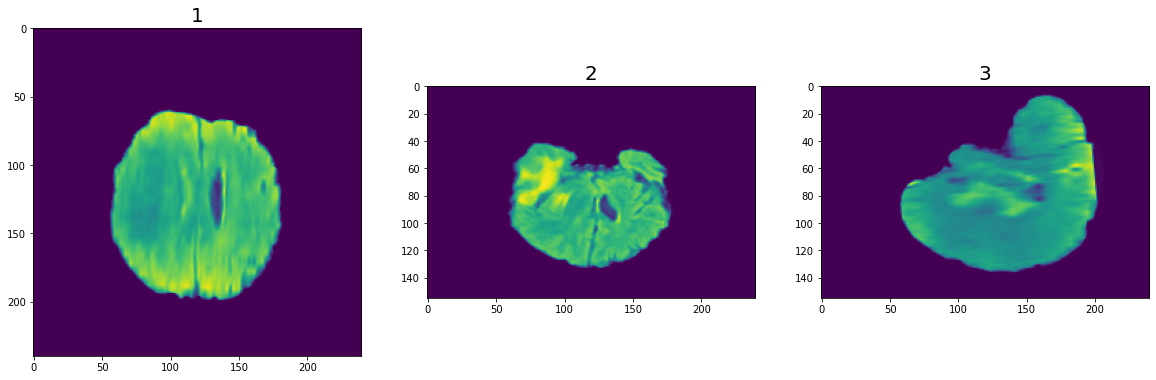

In [ ]:
# görüntü kesitlerinin görselleştirilmesi
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[100,:,:])
plt.title("1", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,100,:])
plt.title("2", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,100])
plt.title("3", fontsize=20);


In [ ]:
flair[1]

'/content/drive/My Drive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_3_1/BraTS19_2013_3_1_flair.nii.gz'

In [ ]:
#boyut ve tip analizi
seg_img = io.imread('/content/drive/MyDrive/uygulama/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


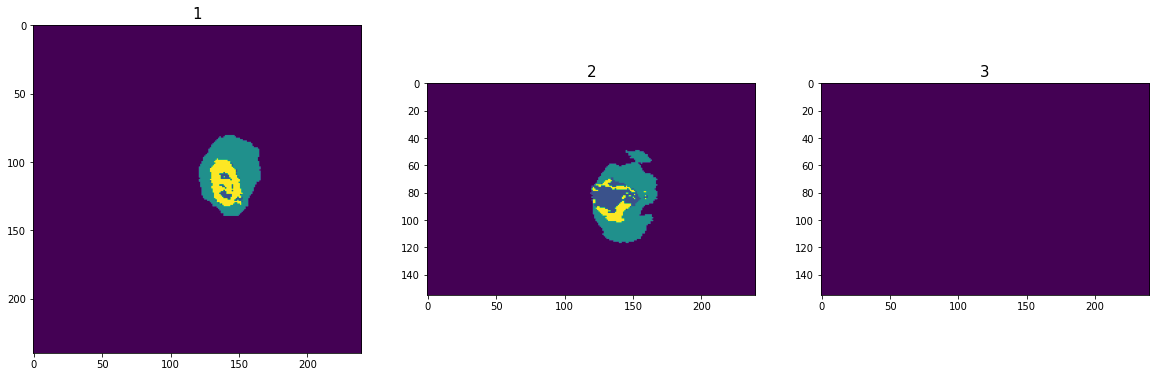

In [ ]:
#segmentasyon görüntü kesitleri
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("1", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("2", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("3", fontsize=15);

In [ ]:
# tam tümör görüntü arraylerinin oluşturulması için definasyon :

def to_array(path, end):
    
    # dosya yolu ile görüntüleri getirme
    files = glob.glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standartlaştırma
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(80,110):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (224,224))    # alınan hatalar nedeniyle görüntülerin 240x240 boyutundan 224x224 boyutuna düşürülme işlemi
            img_s = np.expand_dims(img_s, axis=0)  # boyut genişletme işlemi
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [ ]:
#definasyon test
train = to_array(path=path, end="**/*flair.nii.gz")

In [ ]:
train.shape

(3626, 1, 128, 128)

In [ ]:
#farklı tümör alan görüntülerinin array haline getirilmesi için definasyon:

def seg_to_array(path, end, label):
    
    # dosya yolu ile getirme
    files = glob.glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # tam tümör
        if label == 1:
            img[img != 0] = 1
        
        # Nekroz Tümör Alanı
        if label == 2:
            img[img != 1] = 0
        
        # Ödemsiz Tümör Alanı
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Genişleyen Tümör Alanı
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(80, 110):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (224,224)) # 224x224
            img_s = np.expand_dims(img_s, axis=0) # boyut genişletme
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [ ]:
# flair görüntüleri için array
t_flair =to_array(path=path, end = "**/*flair.nii.gz")

In [ ]:
t_flair.shape

(7770, 1, 224, 224)

In [ ]:
# t2 görüntüleri için array
t_t2 =to_array(path=path, end = "**/*t2.nii.gz")

In [ ]:
t_t2.shape

(7770, 1, 224, 224)

In [ ]:
# t1 görüntüleri için array
t1_data =to_array(path=path, end = "**/*t1.nii.gz")

In [ ]:
t1_data.shape

(7770, 1, 224, 224)

In [ ]:
X_train = np.concatenate((t_flair, t_t2), axis=1)

In [ ]:
X_train.shape

(7770, 2, 224, 224)

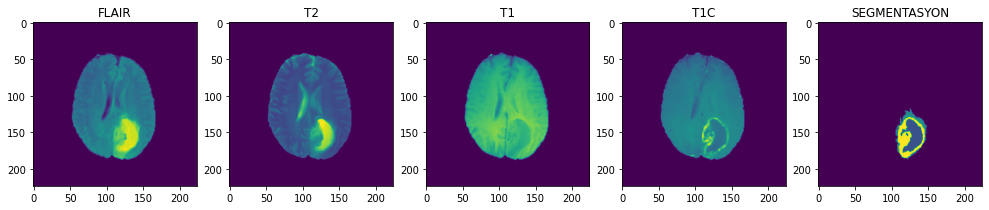

In [ ]:
# veri setindeki FLAIR, T2, T1, T1c ve SEGMENTASYON görüntülerinin görselleştirilnmesi

fig = plt.figure(figsize=(17, 15))
x = 2021
plt.subplot(1,5,1)
plt.title("FLAIR")
plt.imshow(t_flair[x][0])

plt.subplot(1,5,2)
plt.title("T2")
plt.imshow(t_t2[x][0])

plt.subplot(1,5,3)
plt.title("T1")
plt.imshow(t1_data[x][0])

plt.subplot(1,5,4)
plt.title("T1C")
plt.imshow(t1ce_data[x][0])

plt.subplot(1,5,5)
plt.title("SEGMENTASYON")
plt.imshow(seg_data[x][0])

In [ ]:
# tam tümör segmentasyon görüntü arrayi
t_seg = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

In [ ]:
t_seg.shape

(7770, 1, 224, 224)

In [ ]:
# t1c görüntüleri için array
t1cee = to_array(path=path, end="**/*t1ce.nii.gz")

In [ ]:
t1cee.shape

In [ ]:
#t1 görüntüleri için tam tümör segmentasyon arrayi
t111 = to_array(path=path, end="**/*t1.nii.gz", label=1)

In [ ]:
t111.shape

In [ ]:
# depolama alanı test
del t_flair
del t_t2

In [ ]:
# depolama alanı test
t_t2 = np.linspace(0,100, 10000000)
t_t2 = None
del t_t2

In [ ]:
# depolama alanı test
t_flair = a = np.linspace(0,100, 10000000)
t_flair= None
del t_flair

In [ ]:
t_flair.shape

AttributeError: ignored

In [ ]:
# TAM TÜMÖR SEGMENTASYONU İÇİN U-NET MODELİ

def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')


def unet():
    # giriş görüntüleri 224x224 boyutunda
    inputs = Input((2, 224 , 224))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs) # evrişimsel katman
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1) # evrişimsel katman
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)   # Havuzlama işlemi
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model = unet()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# MODEL EĞİTİMİ  batch_size = 32, epochs = 32
model.fit(X_train, t_seg, validation_split=0.25, batch_size=32, epochs=32, shuffle=True)

Epoch 1/32
183/183 [==============================] - 617s 3s/step - loss: 0.8085 - dice_coef: 0.1915 - val_loss: 0.9045 - val_dice_coef: 0.0961
Epoch 2/32
183/183 [==============================] - 521s 3s/step - loss: 0.6355 - dice_coef: 0.3645 - val_loss: 0.8606 - val_dice_coef: 0.1402
Epoch 3/32
183/183 [==============================] - 515s 3s/step - loss: 0.5225 - dice_coef: 0.4775 - val_loss: 0.6478 - val_dice_coef: 0.3544
Epoch 4/32
183/183 [==============================] - 515s 3s/step - loss: 0.3983 - dice_coef: 0.6017 - val_loss: 0.2037 - val_dice_coef: 0.7968
Epoch 5/32
183/183 [==============================] - 515s 3s/step - loss: 0.2770 - dice_coef: 0.7230 - val_loss: 0.1672 - val_dice_coef: 0.8333
Epoch 6/32
183/183 [==============================] - 516s 3s/step - loss: 0.1887 - dice_coef: 0.8113 - val_loss: 0.1905 - val_dice_coef: 0.8100
Epoch 7/32
183/183 [==============================] - 515s 3s/step - loss: 0.1489 - dice_coef: 0.8511 - val_loss: 0.2040 - val_dic

In [ ]:
# model ağırlıklarının saklanması
model.save_weights("/content/drive/MyDrive/uygulama/model_tam.h5")

In [ ]:
# ağırlıkları yükleme
model.load_weights("/content/drive/MyDrive/uygulama/model_tam.h5")

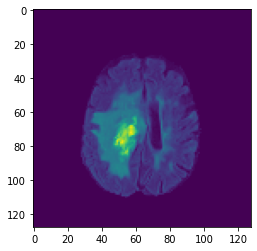

In [ ]:
# EĞİTİM TEST
# Eğitim verilerinden bir görüntü kesiti
plt.imshow(X_train[12222][0]);

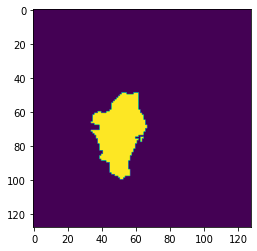

In [ ]:
# EĞİTİM TEST
# Aynı kesitin segmentasyon görüntüsü (orijinal)
plt.imshow(t_seg[12222][0]);

In [ ]:
# MODEL TAHMİNİ
expand_img = np.expand_dims(X_train[12222], axis=0)

pred = model.predict(expand_img)

In [ ]:
expand_img = np.expand_dims(X_train[12222], axis=0)

pred = model.predict(expand_img)

NameError: ignored

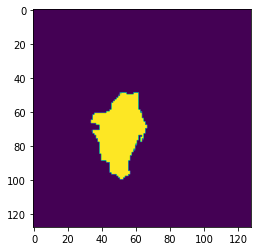

In [ ]:
# MODEL TAHMİN GÖRÜNTÜSÜ
plt.imshow(pred[0][0]);

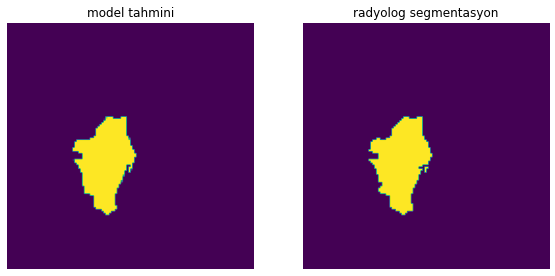

In [ ]:
# KARŞILAŞTIRMA

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.title('model tahmini')
plt.axis('off')
plt.imshow(pred[0][0])

plt.subplot(1,3,2)
plt.title('radyolog segmentasyon')
plt.axis('off')
plt.imshow(t_seg[12222][0])

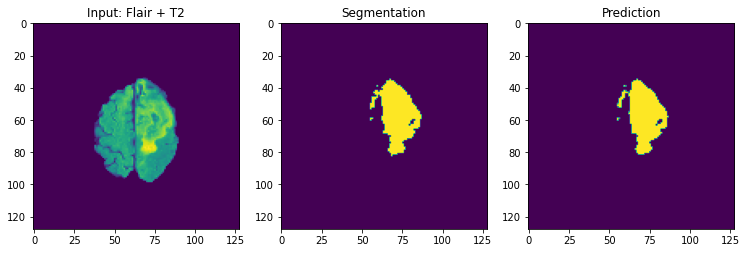

In [ ]:
# MODEL TAHMİNLERİNİN KARŞILAŞTIRILMASI

x = 1020
renk = {0:'magma',           # GÖRSEL EFEKT EKLEME
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot',
        }
a=1 # viridis

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)       # Model Tahminini Elde Etme


# Görselleştirme
fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap=renk[a])

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(t_seg[x][0], cmap=renk[a])

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap=renk[a]);

In [ ]:
# 2 - TÜMÖRÜN FARKLI ALANLARININ SEGMENTASYONU

In [ ]:
# Ödemsiz Tümör Alanı için Array
seg_odemsiz = seg_to_array(path=path, end="**/*seg.nii.gz", label=3)

In [ ]:
seg_odemsiz.shape

(7770, 1, 224, 224)

In [ ]:
# Ödemsiz Görüntü üzerinde veri analizi
tmp = seg_odemsiz[245,0,:,:]

In [ ]:
tmp.shape

(128, 128)

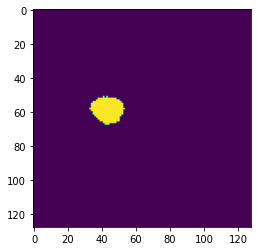

In [ ]:
plt.imshow(tmp)

In [ ]:
# GÖRÜNTÜ KIRPMA İŞLEMLERİ İÇİN VERİ ANALİZİ

In [ ]:
tmp[tmp>0.2] = 1
tmp[tmp!= 1] = 0

In [ ]:
index_xy = np.where(tmp == 1)

In [ ]:
index_xy

(array([ 92,  92,  92,  93,  93,  93,  93,  93,  93,  93,  94,  94,  94,
         94,  94,  94,  94,  94,  94,  94,  95,  95,  95,  95,  95,  95,
         95,  95,  95,  95,  96,  96,  96,  96,  96,  96,  96,  96,  96,
         96,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  98,  98,
         98,  98,  98,  98,  98,  98,  98,  98,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 102,
        102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 104, 104]),
 array([67, 70, 71, 66, 67, 68, 69, 70, 71, 72, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 65, 66, 67,
        68, 69, 70, 71, 72, 65, 66

In [ ]:
index_xy[0]

array([51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56,
       56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57,
       57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58,
       58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
       63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65,
       65, 65, 65, 65, 65

In [ ]:
index_xy[1]

array([41, 43, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 39,
       40, 41, 42, 43, 44

In [ ]:
merkez_y = (max(index_xy[0]) + min(index_xy[0])) / 2

In [ ]:
merkez_y

59.0

In [ ]:
merkez_x = (max(index_xy[1]) + min(index_xy[1])) / 2

In [ ]:
merkez_x

43.0

In [ ]:
merkez_y,merkez_x

(59.0, 43.0)

In [ ]:
img_x = np.zeros((64,64), np.float32)

img_x.shape

(64, 64)

In [ ]:
img_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# t1c görüntü arrayinin oluşturulması
t_t1c =to_array(path=path, end="**/*t1ce.nii.gz")

In [ ]:
t_t1c.shape

(7770, 1, 224, 224)

In [ ]:
x=t_t1c[245,0,:,:]
x.shape

(128, 128)

In [ ]:
ornek = x[60:80,60:70]

In [ ]:
ornek.shape

(20, 10)

In [ ]:
# 1 görüntü üzerinden görüntü kırpma işleminin uygulanması
img_x[:,:] = x[int(merkez_y - 64/2): int(merkez_y + 64/2), int(merkez_x - 64/2): int(merkez_x + 64/2)]

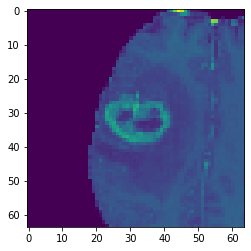

In [ ]:
plt.imshow(img_x)

In [ ]:
seg_ = seg_odemsiz[12222,0,:,:]
seg_.shape

(128, 128)

In [ ]:
# başka bir görüntü üzerinde görüntü kırpma işlemi
img_x[:,:] = seg_[int(merkez_y - 64/2): int(merkez_y + 64/2), int(merkez_x - 64/2): int(merkez_x + 64/2)]

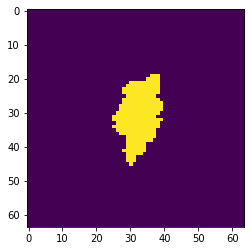

In [ ]:
plt.imshow(img_x)

In [ ]:
img_x.shape

(64, 64)

In [ ]:
# Görüntü Kırpma Arrayinin oluşturulması
def tümör_kirpma1(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy2 = np.where(tmp==1)
    
    if index_xy2[0] != []:
        merkez_y = (max(index_xy2[0]) + (min(index_xy2[0])) ) / 2
        merkez_x = (max(index_xy2[1]) + (min(index_xy2[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2)]
        liste.append(img_x)
        
    return np.array(liste)

In [ ]:
# genişleyen tümör alanı arrayi
seg_genis = seg_to_array(path=path, end="**/*seg.nii.gz", label=4)

In [ ]:
seg_genis.shape

(7770, 1, 224, 224)

In [ ]:
# nekroz tümör alanı arrayi
seg_nekroz = seg_to_array(path=path, end="**/*seg.nii.gz", label=2)

In [ ]:
seg_nekroz.shape

(7770, 1, 224, 224)

In [ ]:
# Görüntü Kırpma TEST
t1c_def = tümör_kırpma(t_t1c[12222],seg_odemsiz[12222])
genis_def = tümör_kırpma(seg_genis[12222],seg_odemsiz[12222])
odemsiz_def = tümör_kırpma(seg_odemsiz[12222],seg_odemsiz[12222])
nekroz_def = tümör_kırpma(seg_nekroz[12222],seg_odemsiz[12222])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Görüntü Kırpma TEST
t2_def2 = tümör_kırpma(t_t2[260],seg_odemsiz[260])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


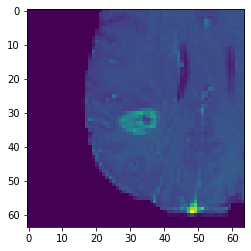

In [ ]:
plt.imshow(t1c_def2[0])

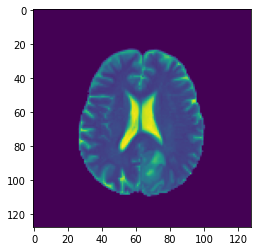

In [ ]:
plt.imshow(t_t2[232][0])

In [ ]:
# GÖRÜNTÜ KIRPMA DEFİNASYONU BOYUT HATASI : ANALİZ ------------

In [ ]:
tmp = t_t1c[232,0,:,:]
tmp[tmp>0.2] = 1
tmp[tmp!= 1] = 0
index_xyz = np.where(tmp == 1)

In [ ]:
index_xyz

(array([ 24,  24,  24, ..., 107, 107, 107]),
 array([52, 53, 54, ..., 73, 74, 75]))

In [ ]:
tmp2 = t_t2[231,0,:,:]
tmp2[tmp2>0.2] = 1
tmp2[tmp2!= 1] = 0
index_xy2 = np.where(tmp2 == 1)

In [ ]:
index_xy2

(array([ 23,  23,  23, ..., 109, 109, 109]),
 array([56, 57, 58, ..., 68, 69, 70]))

In [ ]:
tmp3 = seg_odemsiz[232,0,:,:]
tmp3[tmp3>0.2] = 1
tmp3[tmp3!= 1] = 0
index_xy3 = np.where(tmp3 == 1)

In [ ]:
index_xy3

(array([ 92,  92,  93,  93,  93,  93,  93,  94,  94,  94,  94,  94,  95,
         95,  95,  95,  95,  95,  96,  96,  96,  96,  96,  96,  97,  97,
         97,  97,  97,  97,  98,  98,  98,  98,  98,  99,  99,  99,  99,
        100, 100, 100, 100, 100, 101, 101, 101, 101, 102]),
 array([69, 70, 67, 68, 69, 70, 71, 67, 68, 69, 70, 71, 66, 67, 68, 69, 70,
        71, 66, 67, 68, 69, 70, 71, 66, 67, 68, 69, 70, 71, 66, 67, 68, 69,
        70, 67, 68, 69, 70, 66, 67, 68, 69, 70, 67, 68, 69, 70, 68]))

In [ ]:

center_y = (max(index_xy3[0]) + min(index_xy3[0])) / 2
center_y

97.0

In [ ]:

center_x = (max(index_xy3[1]) + min(index_xy3[1])) / 2
int(center_x)

68

In [ ]:
img_x3 = np.zeros((64,64), np.float32)

img_x3.shape

(64, 64)

In [ ]:
dene = seg_odemsiz[232,0,:,:]
dene.shape

(128, 128)

In [ ]:
# ANALİZ BİTİŞ  ------------------

In [ ]:
# Kırpılan Görüntüleri Array Olarak Tutma İşlemi
def tumor_to_array(tumor, segmentation):

  im_list = []

  for i in range(len(segmentation)):
    img = tümör_kirpma1(tumor[i], seg_odemsiz[i])

    if len(img.shape) > 2:
      im_list.append(img)

  return np.array(im_list)

In [ ]:
# kırpılmış t1c görüntü arrayi
t1ce_array = tumor_to_array(t_t1c,seg_odemsiz)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# kırpılmış genişleyen alan görüntü arrayi
geniş_array = tumor_to_array(seg_genis,seg_odemsiz)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# kırpılmış ödemsiz alan görüntü arrayi
ödemsiz_array = tumor_to_array(seg_odemsiz,seg_odemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
t1ce_array.shape, ödemsiz_array.shape, geniş_array.shape

((5697, 1, 64, 64), (5697, 1, 64, 64), (5697, 1, 64, 64))

In [ ]:
for i in range(len(seg_odemsiz)):
  t_t1c[i].shape

In [ ]:
# BOYUT HATASI
liste_ = []

for i in range(len(seg_odemsiz)):
    img = tümör_kırpma(t_t1c[i],seg_odemsiz[i])
    if len(img.shape) > 2:
        liste_.append(img)
        print(f'{i}')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

In [ ]:
# GELİŞTİRİLMİŞ KIRPMA DEFİNASYONU

def tümör_kırp(x, pred, size): 

    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0:  # boyut 0 ise boş döndür
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2  # merkez noktalarının belirlenmesi
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64      # 64x64 ise  kırp ve array'e ekle 
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128      # 64x128 ise ayrı ayrı kırp ve iki kesit olarak döndür
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       # 128x64 aynı şekilde iki kesit
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128      # 128x128 ise 4 kesitli olarak döndür
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   

In [ ]:
#tümör_kırp TEST
image1, coord1 = tümör_kırp(t_t1c[240,:,:,:],seg[240,:,:,:],64)
image2, coord2 = tümör_kırp(seg_genis[240,:,:,:],seg[240,:,:,:],64)
image3, coord3 = tümör_kırp(seg_odemsiz[240,:,:,:],seg[240,:,:,:],64)

In [ ]:
#tümör_kırp TEST
image1.shape,image2.shape,image3.shape


((1, 1, 64, 64), (1, 1, 64, 64), (1, 1, 64, 64))

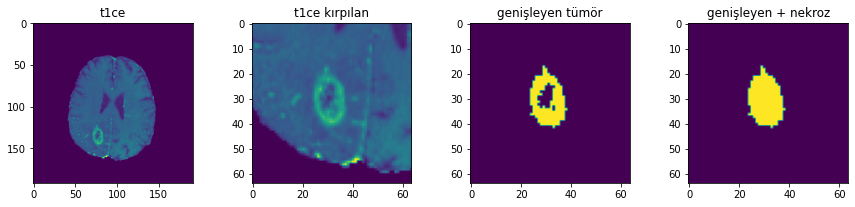

In [ ]:
#tümör_kırp TEST
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t_t1c[240,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılan')
plt.imshow(image1[0,0,:,:])

plt.subplot(3,4,3)
plt.title('genişleyen tümör')
plt.imshow(image2[0,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen + nekroz')
plt.imshow(image3[0,0,:,:])

In [ ]:
#tümör_kırp TEST
image4, coord1 = tümör_kırp(t_t1c[70,:,:,:],seg[70,:,:,:],64)
image5, coord2 = tümör_kırp(seg_genis[70,:,:,:],seg[70,:,:,:],64)
image6, coord3 = tümör_kırp(seg_odemsiz[70,:,:,:],seg[70,:,:,:],64)

In [ ]:
#tümör_kırp TEST
image4.shape,image5.shape,image6.shape

((2, 1, 64, 64), (2, 1, 64, 64), (2, 1, 64, 64))

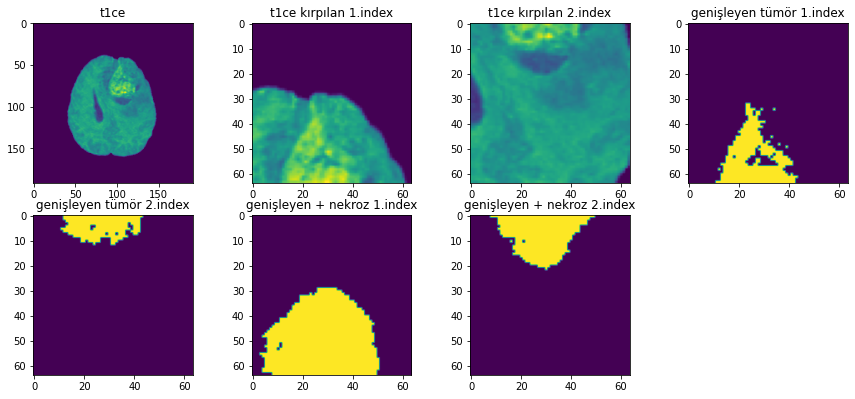

In [ ]:
#tümör_kırp TEST
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t_t1c[70,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılan 1.index')
plt.imshow(image4[0,0,:,:])

plt.subplot(3,4,3)
plt.title('t1ce kırpılan 2.index')
plt.imshow(image4[1,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen tümör 1.index')
plt.imshow(image5[0,0,:,:])

plt.subplot(3,4,5)
plt.title('genişleyen tümör 2.index')
plt.imshow(image5[1,0,:,:])

plt.subplot(3,4,6)
plt.title('genişleyen + nekroz 1.index')
plt.imshow(image6[0,0,:,:])

plt.subplot(3,4,7)
plt.title('genişleyen + nekroz 2.index')
plt.imshow(image6[1,0,:,:])

In [ ]:
# kırpılan görüntüler ile array oluşturma definasyonu:
def tumor2array(tumor,segmentasyon):

    liste = []

    for i in range(len(tumor)):
        crop , kordinat = tümör_kırp(tumor[i,:,:,:],segmentasyon[i,:,:,:],64)
    
        if crop == []:
            pass
        elif crop.shape[0] ==1:
            liste.append(crop[0])
        
        elif crop.shape[0] ==2:
        
           liste.append(crop[0])
           liste.append(crop[1])
        
        elif crop.shape[0] ==4:
        
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3]) 
    
    return np.array(liste)

In [ ]:
# Kırpılmış görüntü arraylerinin oluşturulması
t1ce_array = tumor2array(t_t1c,t_seg)
geniş_array = tumor2array(seg_genis,t_seg)
ödemsiz_array = tumor2array(seg_odemsiz,t_seg)
t1ce_array.shape, ödemsiz_array.shape, geniş_array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


((9220, 1, 64, 64), (9220, 1, 64, 64), (9220, 1, 64, 64))

In [ ]:
# Boyut Hatası : 128x128 boyutundaki görüntüler 224x224 haline getirilip çözülmüştür.
genisleyen_array = tumor_to_array(seg_genis,seg_odemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


ValueError: ignored

In [ ]:
# Boyut Hatası : 128x128 boyutundaki görüntüler 224x224 haline getirilip çözülmüştür.
odemsiz_array = tumor_to_array(seg_odemsiz,seg_odemsiz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


ValueError: ignored

In [ ]:
# Farklı Tümör Alanlarının Segmantasyonunu Yapan Model Eğitimi - U-Net Modeli

def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')

def unet2():
    
    inputs = Input((1, 64 , 64))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model_odemsiz = unet2()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# MODEL EĞİTİMİ - ÖDEMSİZ TÜMÖR ALANI  ( batch_size = 64, epochs = 32 )

history = model_odemsiz.fit(t1ce_array, 
                                  ödemsiz_array, 
                                  validation_split=0.25, 
                                  batch_size=64, 
                                  epochs=32, 
                                  shuffle=True)

Epoch 1/32
109/109 [==============================] - 87s 451ms/step - loss: 0.6057 - dice_coef: 0.3943 - val_loss: 0.9057 - val_dice_coef: 0.0921
Epoch 2/32
109/109 [==============================] - 46s 423ms/step - loss: 0.3248 - dice_coef: 0.6752 - val_loss: 0.6058 - val_dice_coef: 0.3841
Epoch 3/32
109/109 [==============================] - 46s 423ms/step - loss: 0.2452 - dice_coef: 0.7548 - val_loss: 0.3937 - val_dice_coef: 0.5906
Epoch 4/32
109/109 [==============================] - 46s 424ms/step - loss: 0.1747 - dice_coef: 0.8253 - val_loss: 0.2724 - val_dice_coef: 0.7085
Epoch 5/32
109/109 [==============================] - 46s 424ms/step - loss: 0.1280 - dice_coef: 0.8719 - val_loss: 0.2340 - val_dice_coef: 0.7458
Epoch 6/32
109/109 [==============================] - 46s 423ms/step - loss: 0.1116 - dice_coef: 0.8884 - val_loss: 0.2275 - val_dice_coef: 0.7521
Epoch 7/32
109/109 [==============================] - 46s 423ms/step - loss: 0.1065 - dice_coef: 0.8934 - val_loss: 0.

In [ ]:
model_genisleyen = unet2()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# MODEL EĞİTİMİ - GENİŞLEYEN TÜMÖR ALANI ( batch_size = 64, epochs = 32 )

history = model_genisleyen.fit(t1ce_array, 
                                  geniş_array, 
                                  validation_split=0.25, 
                                  batch_size=64, 
                                  epochs=32, 
                                  shuffle=True)

Epoch 1/32
109/109 [==============================] - 49s 429ms/step - loss: 0.6953 - dice_coef: 0.3047 - val_loss: 0.6404 - val_dice_coef: 0.3500
Epoch 2/32
109/109 [==============================] - 46s 423ms/step - loss: 0.4740 - dice_coef: 0.5259 - val_loss: 0.4334 - val_dice_coef: 0.5516
Epoch 3/32
109/109 [==============================] - 46s 424ms/step - loss: 0.3843 - dice_coef: 0.6158 - val_loss: 0.3825 - val_dice_coef: 0.6011
Epoch 4/32
109/109 [==============================] - 46s 424ms/step - loss: 0.3297 - dice_coef: 0.6703 - val_loss: 0.2907 - val_dice_coef: 0.6906
Epoch 5/32
109/109 [==============================] - 46s 424ms/step - loss: 0.2586 - dice_coef: 0.7414 - val_loss: 0.2422 - val_dice_coef: 0.7376
Epoch 6/32
109/109 [==============================] - 46s 423ms/step - loss: 0.2319 - dice_coef: 0.7681 - val_loss: 0.2251 - val_dice_coef: 0.7544
Epoch 7/32
109/109 [==============================] - 46s 423ms/step - loss: 0.1878 - dice_coef: 0.8121 - val_loss: 0.

In [ ]:
# Model Ağırlıklarının Saklanması
model_genisleyen.save_weights("/content/drive/MyDrive/uygulama/model_genis.h5")

In [ ]:
model_odemsiz.save_weights("/content/drive/MyDrive/uygulama/model_odemsiz.h5")

In [ ]:
# Model Ağırlıklarını Yükleme
model_genisleyen.load_weights("/content/drive/MyDrive/uygulama/model_genis.h5")

In [ ]:
model_odemsiz.load_weights("/content/drive/MyDrive/uygulama/model_odemsiz.h5")

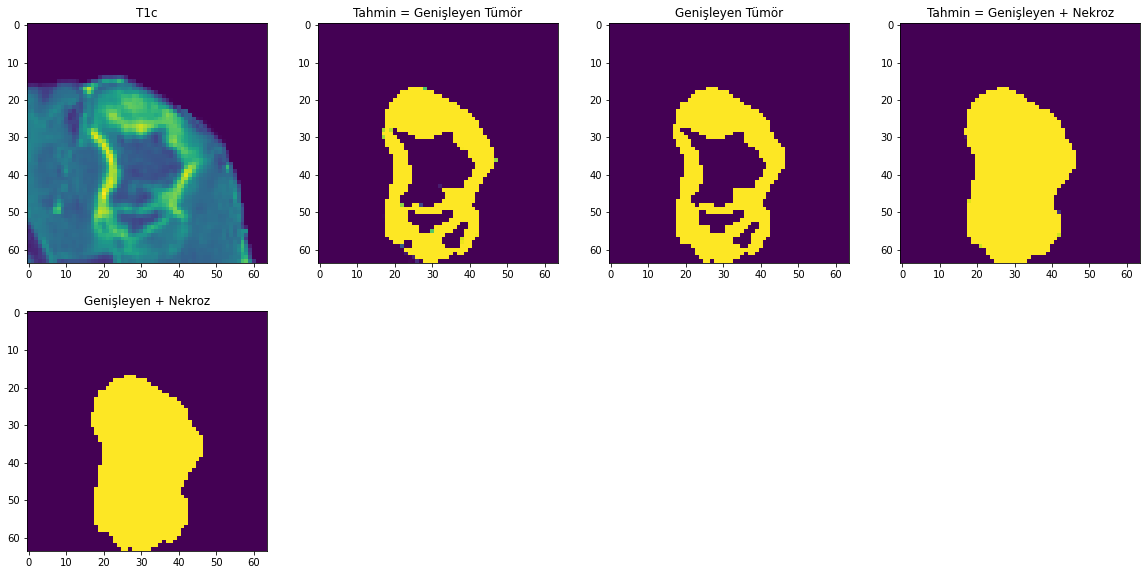

In [ ]:
# Modellerin Tahminlerinin Karşılaştırılması
x=4600
plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.title('T1c')
plt.imshow(t1ce_array[x,0,:,:])

genis_pred = model_genisleyen.predict(t1ce_array[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Tahmin = Genişleyen Tümör')
plt.imshow(genis_pred[0,0,:,:])

plt.subplot(3,4,3)
plt.title('Genişleyen Tümör')
plt.imshow(geniş_array[x,0,:,:])

odemsiz_pred = model_odemsiz.predict(t1ce_array[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Tahmin = Genişleyen + Nekroz')
plt.imshow(odemsiz_pred[0,0,:,:])

plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz_array[x,0,:,:])

In [ ]:
# orijinal segmentasyon görüntü arrayi
seg_orj = to_array(path=path, end="**/*seg.nii.gz")

In [ ]:
seg_orj.shape

(7770, 1, 224, 224)

In [ ]:
# Oluşturulan 3 Model Tahminlerinin Üst Üste Eklenerek Birleştirilmesi

def üstüne_ekle(pred_tam, pred_ödemsiz , pred_geniş , koordinat):  
    
    total = np.zeros((1,224,224),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_ödemsiz.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_ödemsiz[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_ödemsiz[i,0,j,k]
                    
                if pred_geniş[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_geniş[i,0,j,k]
                
    return total

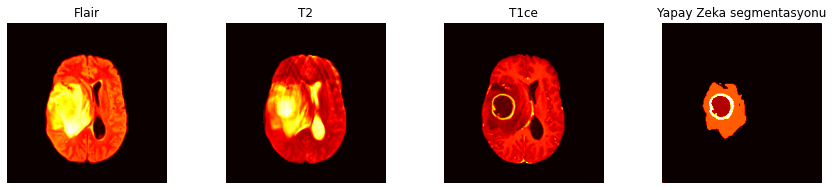

In [ ]:
                # TEST
# OLUŞTURULAN SONUÇ GÖRSELİNİN TEST EDİLMESİ

renk = {0:'magma',       # EFEKTLER
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 5

x = 1772  # TEST EDİLECEK GÖRÜNTÜ        1772

görüntü , koordinat = tümör_kırp(t_t1c[x,:,:,:],t_seg[x,:,:,:],64)
pred_ödemsiz = model_odemsiz.predict(görüntü)
pred_geniş = model_genisleyen.predict(görüntü)
pred_tam = model.predict(X_train[x-1:x,:,:,:])
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0
pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0
pred_geniş[pred_geniş > 0.2] = 4
pred_geniş[pred_geniş != 4 ] = 0
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_ödemsiz, pred_geniş, koordinat)


plt.figure(figsize=(15,10))

plt.subplot(341)
plt.title('Flair')
plt.axis('off')
plt.imshow(X_train[x, 0, :, :],cmap= renk[a])

plt.subplot(342)
plt.title('T2')
plt.axis('off')
plt.imshow(X_train[x, 1, :, :],cmap= renk[a])
    
plt.subplot(343)
plt.title('T1ce')
plt.axis('off')
plt.imshow(t_t1c[x, 0, :, :],cmap= renk[a])

# -- RAM yetersiz olduğu için aynı kesit görüntüler için proje kodları tekrar çalıştırılıp,   -- 
# -- Orijinal Görüntüler sonraki grafik kodu üzerinden görselleştirilerek karşılaştırılmıştır.  -- 

#plt.subplot(344)
#plt.title('Radyolog segmentasyonu')
#plt.axis('off')
#plt.imshow(seg_orj[x, 0, :, :],cmap= renk[a])

#plt.subplot(345)
#plt.title('Genişleyen tümör')
#plt.axis('off')
#plt.imshow(seg_geniş[x, 0, :, :],cmap= renk[a])

#plt.subplot(346)
#plt.title('Genişleyen + Nekroz ')
#plt.axis('off')
#plt.imshow(seg_ödemsiz[x, 0, :, :],cmap= renk[a])

#plt.subplot(347)
#plt.title('Nekroz')
#plt.axis('off')
#plt.imshow(seg_nekroz[x, 0, :, :],cmap= renk[a])

plt.subplot(344)
plt.title('Yapay Zeka segmentasyonu')
plt.axis('off')
plt.imshow(deneme[ 0, :, :],cmap=renk[a])

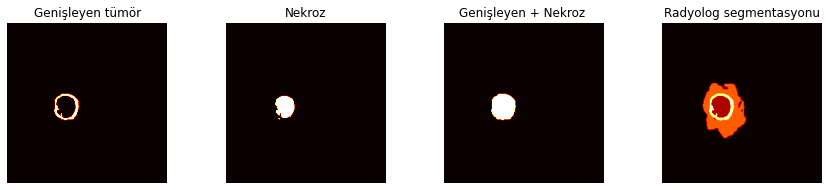

In [ ]:
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',    # EFEKTLER
        5:'hot', }
a    = 5

x = 1772  # TEST EDİLECEK GÖRÜNTÜ                  1772

plt.figure(figsize=(15,10))



plt.subplot(341)
plt.title('Genişleyen tümör')
plt.axis('off')
plt.imshow(seg_genis[x, 0, :, :],cmap= renk[a])

plt.subplot(342)
plt.title('Nekroz')
plt.axis('off')
plt.imshow(seg_nekroz[x, 0, :, :],cmap= renk[a])

plt.subplot(343)
plt.title('Genişleyen + Nekroz ')
plt.axis('off')
plt.imshow(seg_odemsiz[x, 0, :, :],cmap= renk[a])

plt.subplot(344)
plt.title('Radyolog segmentasyonu')
plt.axis('off')
plt.imshow(seg_orj[x, 0, :, :],cmap= renk[a])